In [1]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, plotTrajectoriesFile
from parcels import Field
import parcels
import numpy as np
import math
from datetime import timedelta as delta
from datetime import timedelta
from operator import attrgetter

##should save import parcels only in the future

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from netCDF4 import Dataset
import matplotlib.animation as animation
from matplotlib import rc
import matplotlib.lines as lines

from parcels.loggers import logger
from os import path


### Start with defining fields


In [3]:
class CGS_field:
    """CGS flow field that simulates the environmental flows.
    The field can be initialized by the velocities of flows in given positions.
    """
    
    def __init__(self,x_vel,y_vel):
        """CGS field can be initialized by assigning the velocities in given positions.
        The velocities should be in the form of 2-dimensional numpy arrays, with postive values pointing to right or up.
        For example, if x_vel is [[1,1,1,1],[5,5,5,5]], it means that the velocities in x direction are 1 when y is 1, and 
        are 5 when y is 2. If the velocities are negative, it means the velocities go in negative x direction(to the left).
        """
        
        ## make sure the dimensions of x_vel are equal to those of y_vel
        if x_vel.shape != y_vel.shape:
            raise RuntimeError("The dimensions of x_vel should be the same as those of y_vel")
        
        self.x_velocities = x_vel
        self.y_velocities = y_vel
        
        ## initialize parcels fields with lon and lat values set according to the len(x_vel) and len(y_vel)
        field_x = parcels.Field(name='U',data=x_vel,lon=np.linspace(start=0,stop=1,num=len(x_vel[0])),\
                                lat=np.linspace(start=0,stop=1,num=len(x_vel)))
        field_y = parcels.Field(name='V',data=y_vel,lon=np.linspace(start=0,stop=1,num=len(y_vel[0])),\
                                lat=np.linspace(start=0,stop=1,num=len(y_vel)))
        
        ## initialize parcels fieldsets with fields created above
        fieldset = parcels.FieldSet(U=field_x,V=field_y)
        
        self.fieldset = fieldset
        
    def deploy_kernels(self,x_pos,y_pos,pclass):
        """Deploy kernels on the flow field created above. 
        The postions of kernels in x and y directions should be provided in 1-dimension numpy arrays respectively.
        For example, if two kernels are created, and the x_pos and y_pos are set as [1,2] and [3,4], then
        the positions of the kernels will be at [1,3] and [2,4] respectively.
        """
        
        ## set the pclass to be self-defined kernel
        
        ## the kernels should be customized in the future
        kset = kernel_set(fieldset=self.fieldset,pclass=pclass,lon=x_pos,lat=y_pos)
        self.kset = kset
    
    def simulate(self,time_length,period,output_filename):
        """Do the simulation.
        The total time length and period of simulation should be provided.
        """
        ## do the simulation with time information provided above. outputfile updated with period provided above.
        kset=self.kset
        kset.execute(pyfunc=AdvectionRK4,runtime=timedelta(minutes=time_length),dt=timedelta(minutes=period),\
                         output_file=kernel_file(name=output_filename,particleset=kset,outputdt=timedelta(minutes=period)))
        
    def plot_trajectories(self,file_name,mode=None):
        """Plot the trajectories of the kernels within the flow field.
        Can choose the moving mode to show the animated trajectories.
        """
        
        if mode == 'moving':
            print('moving')
            return plot_kernel_trajectories(filename=file_name+'.nc', mode='movie2d_notebook')
        else:
            return plot_kernel_trajectories(filename=file_name+'.nc')

In [4]:
class kernel_file(parcels.ParticleFile):
    """Inherit from parcels.ParticleFile.
    Add additional dimension: 'nd', and additional varaible: 'kernel_array' in netCDF file to save nd_array of kernels.
    """
    def __init__(self, name, particleset, outputdt=np.infty, write_ondelete=False):
        super(kernel_file,self).__init__(name, particleset, outputdt=outputdt, write_ondelete=write_ondelete)
        self.dataset.createDimension('nd',None)
        self.kernel_array = self.dataset.createVariable('kernel_array','f4',['nd','traj','obs'],fill_value=np.nan)
        
    def write(self, pset, time, sync=True, deleted_only=False):
        """Write function of class kernel_file.
        save nd_array of kernels to netCDF file.
        """
        if isinstance(time, delta):
            time = time.total_seconds()
        if self.lasttime_written != time and \
           (self.write_ondelete is False or deleted_only is True):
            if pset.size > 0:

                first_write = [p for p in pset if p.fileid < 0 or len(self.idx) == 0]  # len(self.idx)==0 in case pset is written to new ParticleFile
                for p in first_write:
                    p.fileid = self.lasttraj
                    self.lasttraj += 1

                self.idx = np.append(self.idx, np.zeros(len(first_write)))

                for p in pset:
                    i = p.fileid
                    self.id[i, self.idx[i]] = p.id
                    self.time[i, self.idx[i]] = time
                    self.lat[i, self.idx[i]] = p.lat
                    self.lon[i, self.idx[i]] = p.lon
                    self.z[i, self.idx[i]] = p.depth 
                    ##save nd_array in netCDF file
                    self.kernel_array[:, i, self.idx[i]] = p.nd_array
                    for var in self.user_vars:
                        getattr(self, var)[i, self.idx[i]] = getattr(p, var)
                for p in first_write:
                    for var in self.user_vars_once:
                        getattr(self, var)[p.fileid] = getattr(p, var)
            else:
                logger.warning("ParticleSet is empty on writing as array")

            if not deleted_only:
                self.idx += 1
                self.lasttime_written = time

        if sync:
            self.sync() 

In [5]:
class kernel(parcels.ScipyParticle):
    """Inherit kernels from ScipyParticle in parcels.
    Add additional n-dimensional kernel.
    """
    def __init__(self, lon, lat, fieldset, depth=0., time=0., cptr=None):
        """The nd_array serves as additional attributes of ScipyParticle.
        The nd_array should be given in the form of numpy array. 
        """
        super(kernel,self).__init__(lon, lat, fieldset, depth=0., time=0., cptr=None)
        
    def set_kernel(self,nd_array):
        """Set the values of nd_array of the kernel.
        """
        self.nd_array = nd_array

In [6]:
class kernel_set(parcels.ParticleSet):
    def __init__(self, fieldset, pclass=kernel, lon=[], lat=[], depth=None, time=None, repeatdt=None):
        super(kernel_set,self).__init__(fieldset=fieldset, pclass=pclass, lon=lon, lat=lat, depth=None, time=None, repeatdt=None)
    
    def set_kernels(self,nd_array,indices):
        for index in indices:
            self.particles[index].set_kernel(nd_array)

In [7]:
def plot_kernel_trajectories(filename, mode='2d', show_plt=True):
    
    pfile = Dataset(filename, 'r')
    lon = np.ma.filled(pfile.variables['lon'], np.nan)
    lat = np.ma.filled(pfile.variables['lat'], np.nan)
    time = np.ma.filled(pfile.variables['time'], np.nan)
    z = np.ma.filled(pfile.variables['z'], np.nan)
    nd_array = np.ma.filled(pfile.variables['kernel_array'], np.nan)[:,:,0]
    
    radius = 0.03
    
    if mode == '2d':
        fig, ax = plt.subplots()
        ##the amount of kernels
        for kernel_id in range(len(lon)):
            ##the amount of positions sampled
            for pos in range(len(lon[0])):
                #print(nd_array[:,kernel_id])
                ax.add_patch(plot_kernels(lon[kernel_id,pos], lat[kernel_id,pos], nd_array[:,kernel_id], radius))
                if pos != len(lon[1])-1:
                    temp_x = [lon[kernel_id,pos],lon[kernel_id,pos+1]]
                    temp_y = [lat[kernel_id,pos],lat[kernel_id,pos+1]]
                    ax.add_line(plot_lines(temp_x,temp_y,0.001))
        plt.show()
        return plt
        
    elif mode == 'movie2d_notebook':
        fig = plt.figure()
        ax = plt.axes(xlim=(np.nanmin(lon), np.nanmax(lon)), ylim=(np.nanmin(lat), np.nanmax(lat)))
        plottimes = np.unique(time)
        plottimes = plottimes[~np.isnan(plottimes)]
        b = time == plottimes[0]
        polygons = []
        for ids in range(len(lon[b])):
            polygons.append(plot_kernels(lon[b][ids],lat[b][ids],nd_array[:,ids],radius))
            ax.add_patch(polygons[ids])
        ttl = ax.set_title('Particle at time ' + str(plottimes[0]))
        frames = np.arange(1, len(plottimes))

        def animate(t):
            b = time == plottimes[t]
            for ids in range(len(lon[b])):
                polygons[0].remove()
                del(polygons[0])
                polygons.append(plot_kernels(lon[b][ids],lat[b][ids],nd_array[:,ids],radius))
                ax.add_patch(polygons[len(polygons)-1])
            ttl.set_text('Particle at time ' + str(plottimes[t]))

        rc('animation', html='html5')
        anim = animation.FuncAnimation(fig, animate, frames=frames,
                                       interval=100, blit=False)


        plt.close()
        return anim

In [8]:
def plot_kernels(lon,lat,nd_array,radius,color='b'):
    nd = nd_array[~np.isnan(nd_array)]
    dim = len(nd) + 1
    theta = np.linspace(0,2*np.pi,dim)
    xs = lon + radius * np.cos(theta)
    ys = lat + radius * np.sin(theta) 
    return Polygon(np.column_stack([xs, ys]),color=color)

def plot_lines(lon,lat,lw):
    return lines.Line2D(lon,lat,lw=lw)

#### Randomly testing the functions


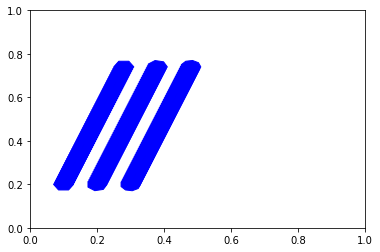

<module 'matplotlib.pyplot' from 'C:\Users\User\Miniconda3\envs\py2_parcels\lib\site-packages\matplotlib\pyplot.pyc'>

In [9]:
## Setting up the velocities in different positions of the flow field.
xv=np.array([[1,1,1,1],[1,1,1,1]],dtype=np.float32)*1e-5
yv=np.array([[3,3,3,3],[3,3,3,3]],dtype=np.float32)*1e-5
cgs=CGS_field(xv,yv)
fname='CGS_simulation3'
## Setting up the initial positions of different kernels
xpos=np.array([1,2,3],dtype=np.float32)*0.1
ypos=np.array([2,2,2],dtype=np.float32)*0.1
ndarray=np.array([1,2,3,4,5,6],dtype=np.float32)
cgs.deploy_kernels(xpos,ypos,kernel)
## Setting up the n-dimension arrays of the kernels
cgs.kset[0].set_kernel(ndarray)
cgs.kset[1].set_kernel(np.array([1,2,3,4,5,6,7],dtype=np.float32))
cgs.kset[2].set_kernel(np.array([1,2,3,4,5,6,7,8,9],dtype=np.float32))
## Do simulation
cgs.simulate(300,5,fname)
cgs.plot_trajectories(fname)

In [10]:
cgs.plot_trajectories(fname,'moving')

moving
